# Fortune 500 Data Collection



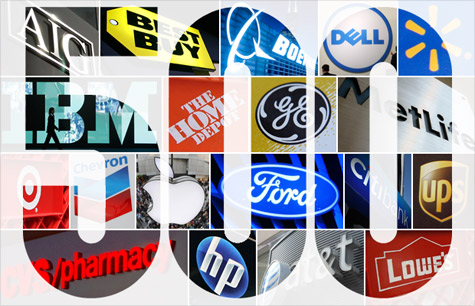 

## Overview

I started this notebook as a way to create a Fortune 500 Company dataset. Originally, I planned on simply scraping the list of companies on the Fortune website, but this website would not be tamed by my usual web scraping skills. I couldn't simply use Beautiful Soup to parse the data and select my desired elements because this web page is dynamic. So this notebook outlines my process for finding a way to get the data.  

The notebook is broken down as follows:
1.  **Network Analysis**
    * Explore the network and data requests used to render our webpage
    * Call the API that supplies the data for the company table   
2.  **JSON Data**
    * Parse the JSON response from the API and select the data we want
    * Create a dataframe and organize data  
3.  **Scraping URLs**
    * Crawl all the individual company Fortune webpages
    * Find the html that contains the data we want and extract it
    * Scrape our data and create a dataframe   
4.  **Joining and Sorting Data**
    * Join our two datasets and sort the rows  
5.  **Conclusion**
    * Convert dataframe to csv file

# 1. Network Analysis

I want to create a dataset of all the companies in the Fortune 500 with some specific information about each. I figure the best way to do that is to go to the actual Fortune Magazine website. 

I planned on scraping information from the list of companies, but unfortunately this is a webpage heavy with javascript where the list changes without reloading the page. This prevents me from just scraping all the list contents direcly from the html. 


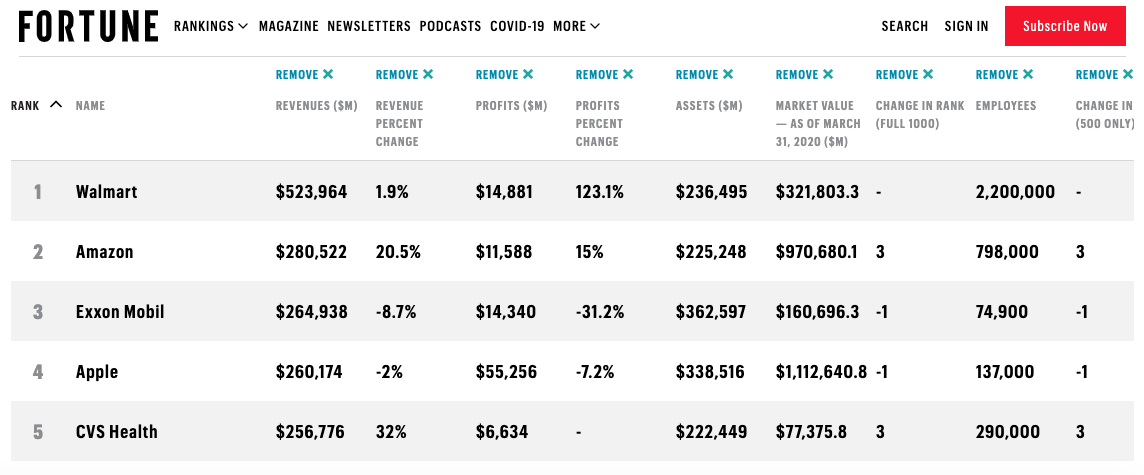

Since traditional web scraping won't work, I suspect there is another source producing the information on this web page. It is likely an API that my browser is calling to get some sort of JSON response and render the information on the page. So I decided to try to find the API that responds with the company data listed in this table. 

To do this we need to right-click on the web page and select "inspect", which will pull up the developer window on our webpage. Then go to the network tab, which will look something like this:

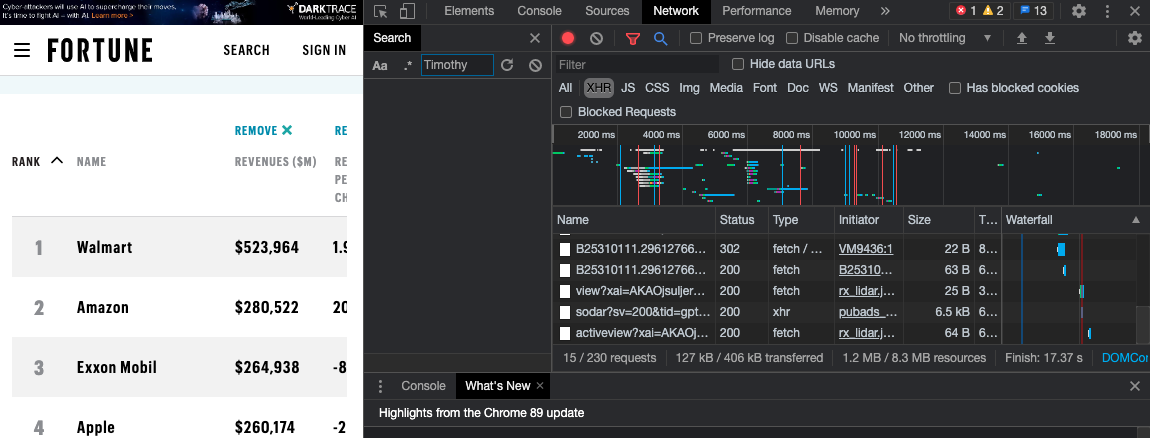

Once there, we will look at the the requests being sent from our browser to different API's. This [article](http://www.gregreda.com/2015/02/15/web-scraping-finding-the-api/) will give you a better understanding of how this works and how to select the API you are looking for.

In [2]:

import os
import time
import sys
import numpy as np
import pandas as pd
import regex as re
import lxml
import numbers
from bs4 import BeautifulSoup
import requests
import json

req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
}

We want to look at the XHR responses in the network tab and try to find any response from a url name that mentions "fortune" or "lists". We poke around a little and find a GET request to the url below that provides us with a JSON repsone. 

In [3]:
page_url = 'https://content.fortune.com/wp-json/irving/v1/data/franchise-search-results?list_id=3287962&token=Zm9ydHVuZTpCcHNyZmtNZCN5SndjWkkhNHFqMndEOTM='

We send a request to the url and it provides us with a JSON response that contains all sorts of data on each company in the list! 

In [4]:
# request the URL and parse the JSON
response = requests.get(page_url)
response.raise_for_status() # raise exception if invalid response
comps = response.json()
print(len(comps))

2


**Now we can begine exploring and parsing the data we want.** 

- Above we see what we actually got back from our request was a list that contained 2 items.

- The second item in the list contains the data we want so we call that one.

In [5]:
comp = comps[1]
print(len(comp))

2


Let's see if we can get a better view of the json data for this company.

In [6]:
# prettify json
format_json = json.dumps(comp, sort_keys=True, indent=5)
print(format_json[:1000])

{
     "items": [
          {
               "fields": [
                    {
                         "key": "rank",
                         "value": "684"
                    },
                    {
                         "key": "f500_revenues",
                         "value": "4099.9"
                    },
                    {
                         "key": "revchange",
                         "value": "54.6"
                    },
                    {
                         "key": "f500_profits",
                         "value": "1375.6"
                    },
                    {
                         "key": "prftchange",
                         "value": "104.6"
                    },
                    {
                         "key": "assets",
                         "value": "7551.3"
                    },
                    {
                         "key": "f500_mktval",
                         "value": "35066.3"
                    },
               

Our comp (companies) variable contains a list of dictionaries for each company. Each company has two parts: 1) a list of dictionaries which contain information about the company, and 2) a dictionary with a link to the company's Fortune page. 



### Let's give an example of one of the companies below

In [7]:
# select the third company
n_comp = comp['items'][2]
print(n_comp)

{'fields': [{'key': 'rank', 'value': '471'}, {'key': 'f500_revenues', 'value': '7038'}, {'key': 'revchange', 'value': '0.2'}, {'key': 'f500_profits', 'value': '-455'}, {'key': 'prftchange', 'value': '-337'}, {'key': 'assets', 'value': '13223'}, {'key': 'f500_mktval', 'value': '3123.3'}, {'key': 'rankchange1000', 'value': '-56'}, {'key': 'f500_employees', 'value': '23300'}, {'key': 'rankchange', 'value': '-56'}, {'key': 'name', 'value': 'Xerox Holdings'}, {'key': 'sector', 'value': 'Technology'}, {'key': 'f500_industry', 'value': 'Computers, Office Equipment'}, {'key': 'hqcity', 'value': 'Norwalk'}, {'key': 'hqstate', 'value': 'CT'}, {'key': 'rankgain', 'value': 'no'}, {'key': 'rankdrop', 'value': 'yes'}, {'key': 'newcomer', 'value': 'no'}, {'key': 'profitable', 'value': 'no'}, {'key': 'ceofounder', 'value': 'no'}, {'key': 'ceowoman', 'value': 'no'}, {'key': 'jobgrowth', 'value': 'no'}, {'key': 'global500-y-n', 'value': 'no'}, {'key': 'best-companies-y-n', 'value': 'no'}, {'fieldMeta': 

The third company in the list is Xcel Energy and it's dictionary has two parts:

1. A "fields" dictionary
2. A "permalink" dictionary

In [8]:
n_comp.keys()

dict_keys(['fields', 'permalink'])

The permalink dictionary returns a link to the company's Fortune webpage.

In [9]:
new_comp = n_comp['permalink']
print(new_comp)

https://fortune.com/company/xerox/fortune500/


The "fields" dictionary returns a list of other dictionaries containing items which populate the main Fortune web page. 

In [10]:
my_comp = n_comp['fields']
print(my_comp)

[{'key': 'rank', 'value': '471'}, {'key': 'f500_revenues', 'value': '7038'}, {'key': 'revchange', 'value': '0.2'}, {'key': 'f500_profits', 'value': '-455'}, {'key': 'prftchange', 'value': '-337'}, {'key': 'assets', 'value': '13223'}, {'key': 'f500_mktval', 'value': '3123.3'}, {'key': 'rankchange1000', 'value': '-56'}, {'key': 'f500_employees', 'value': '23300'}, {'key': 'rankchange', 'value': '-56'}, {'key': 'name', 'value': 'Xerox Holdings'}, {'key': 'sector', 'value': 'Technology'}, {'key': 'f500_industry', 'value': 'Computers, Office Equipment'}, {'key': 'hqcity', 'value': 'Norwalk'}, {'key': 'hqstate', 'value': 'CT'}, {'key': 'rankgain', 'value': 'no'}, {'key': 'rankdrop', 'value': 'yes'}, {'key': 'newcomer', 'value': 'no'}, {'key': 'profitable', 'value': 'no'}, {'key': 'ceofounder', 'value': 'no'}, {'key': 'ceowoman', 'value': 'no'}, {'key': 'jobgrowth', 'value': 'no'}, {'key': 'global500-y-n', 'value': 'no'}, {'key': 'best-companies-y-n', 'value': 'no'}, {'fieldMeta': {'title': '

# 2. JSON Data

Now that we know how our dataset looks, we're going to select info about each company it contains. 

First, grab all of the "field" dictionaries from comp dataset and put them in list. 

In [11]:
fields = []

for j in comp['items']:
    
    #for key, value in comp:
    field = j['fields']
    fields.append(field)
        
print(len(fields))

1000


There are 1000 companies in this list.

### DataFrame

Now we're going to pull the data we want from each company's dictionary and put it into a dataframe. 

Create a dataframe and select the features we want from the json output. 

In [12]:
df = pd.DataFrame()

In [13]:
def gather_data(name, col):

    lst = []
    val = ""
    for i in fields:
        for j in i:
            if j['key'] == name:
                val = j['value']
            else:
                pass
        
        lst.append(val)
        
    df[col] = lst
    
    return df

In [14]:
keys = ['name', 'rank', 'rankchange', 'f500_revenues', 'f500_profits', 
        'f500_employees', 'sector', 'hqcity', 'hqstate', 'newcomer', 
        'ceofounder', 'ceowoman', 'profitable']

cols = ['company', 'rank', 'rank_change', 'revenue', 'profit',
        'num. of employees', 'sector', 'city', 'state', 'newcomer', 
        'ceo_founder', 'ceo_woman', 'profitable']


for x,y in zip(keys, cols):
    f500_df = gather_data(x, y)

In [15]:
print(f500_df.shape)
f500_df.head()

(1000, 13)


,company,rank,rank_change,revenue,profit,num. of employees,sector,city,state,newcomer,ceo_founder,ceo_woman,profitable
0,Zoom Video Communications,684,,4099.9,1375.6,6787,Technology,San Jose,CA,no,yes,no,yes
1,Yum Brands,490,-12,6584,1575,25650,"Hotels, Restaurants & Leisure",Louisville,KY,no,no,no,yes
2,Xerox Holdings,471,-56,7038,-455,23300,Technology,Norwalk,CT,no,no,no,no
3,Xcel Energy,278,-6,13431,1597,11321,Energy,Minneapolis,MN,no,no,no,yes
4,Wynn Resorts,719,,3763.7,-755.8,26950,"Hotels, Restaurants & Leisure",Las Vegas,NV,no,no,no,no


### Data Types and Features

Change our data types to numeric form in columns that show numbers.

In [16]:
f500_df[['rank', 'rank_change', 'revenue', 'profit','num. of employees']] = f500_df[['rank', 'rank_change', 'revenue','profit','num. of employees']].apply(pd.to_numeric)

Fill missing rank change values with zero because they either didn't change ranks or they are newcommers. 

In [17]:
# fill missing values with zero
f500_df['rank_change'] = f500_df['rank_change'].fillna(0)

Check data types

In [18]:
print(f500_df.dtypes)

company               object
rank                   int64
rank_change          float64
revenue              float64
profit               float64
num. of employees    float64
sector                object
city                  object
state                 object
newcomer              object
ceo_founder           object
ceo_woman             object
profitable            object
dtype: object


**New Feature: Previous Rank** 

Now we're going to create a new feature that shows the previous rank (2020) of each company in the Forune 500. Does not apply to companies outside of top 500. 

In [19]:
# Create new features
f500_df['prev_rank'] = (f500_df['rank'] + f500_df['rank_change'])
f500_df.head()

,company,rank,rank_change,revenue,profit,num. of employees,sector,city,state,newcomer,ceo_founder,ceo_woman,profitable,prev_rank
0,Zoom Video Communications,684,0.0,4099.9,1375.6,6787.0,Technology,San Jose,CA,no,yes,no,yes,684.0
1,Yum Brands,490,-12.0,6584.0,1575.0,25650.0,"Hotels, Restaurants & Leisure",Louisville,KY,no,no,no,yes,478.0
2,Xerox Holdings,471,-56.0,7038.0,-455.0,23300.0,Technology,Norwalk,CT,no,no,no,no,415.0
3,Xcel Energy,278,-6.0,13431.0,1597.0,11321.0,Energy,Minneapolis,MN,no,no,no,yes,272.0
4,Wynn Resorts,719,0.0,3763.7,-755.8,26950.0,"Hotels, Restaurants & Leisure",Las Vegas,NV,no,no,no,no,719.0


But we need to account for companies that are newcommers to the 500 and any companies outside of the top 500 (their rank change is not given). If we don't we will get duplicate values. 

In [20]:
# newcommer prev_rank
f500_df.loc[(f500_df['newcomer'] == 'yes')| (f500_df['rank']>499), 'prev_rank'] = " "         

In [21]:
f500_df.head()

,company,rank,rank_change,revenue,profit,num. of employees,sector,city,state,newcomer,ceo_founder,ceo_woman,profitable,prev_rank
0,Zoom Video Communications,684,0.0,4099.9,1375.6,6787.0,Technology,San Jose,CA,no,yes,no,yes,
1,Yum Brands,490,-12.0,6584.0,1575.0,25650.0,"Hotels, Restaurants & Leisure",Louisville,KY,no,no,no,yes,478.0
2,Xerox Holdings,471,-56.0,7038.0,-455.0,23300.0,Technology,Norwalk,CT,no,no,no,no,415.0
3,Xcel Energy,278,-6.0,13431.0,1597.0,11321.0,Energy,Minneapolis,MN,no,no,no,yes,272.0
4,Wynn Resorts,719,0.0,3763.7,-755.8,26950.0,"Hotels, Restaurants & Leisure",Las Vegas,NV,no,no,no,no,


And that is our first dataset.

# 3. Crawl Company Urls

Now we can address the "permalink" varibale in our dictionaries. 

This dictionary contains the link to each company's Fortune webpage.

Grab those links and put them in a list. 

Gather urls:

In [22]:
urls = []

for i in comp['items']:
    
    #for key, value in comp:
    url = i['permalink']
    urls.append(url)
        
print(len(urls))

1000


Crawl each of these urls and pull the infromation from the page for:

- website url
- CEO
- Ticker
- Market cap


For each company in the list, we will crawl their Fortune 500 company page and scrape the information we desire.  

### Another Roadblock

Interestingly, the data we want cannot be scraped by simply looking at the developer window and calling the elements representing the corresponding values. You can see in the photo below, the CEO name is represented by a "div" element and in the "info__value--2AHH7" class, but when we call those elements it returns an empty dataset. 

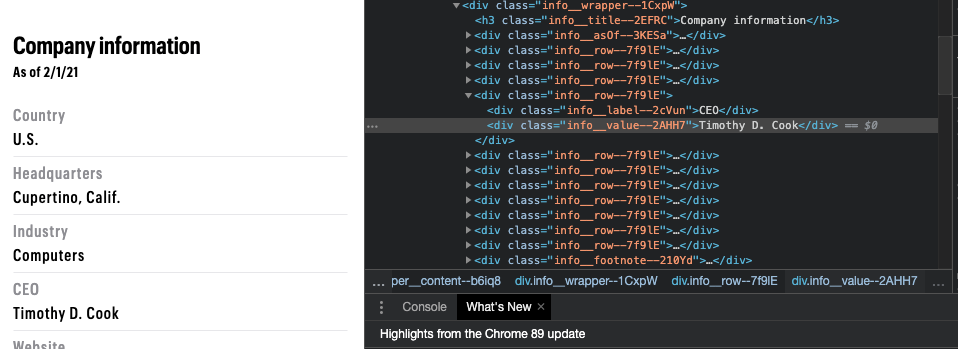

Looks like I need to be a little more creative, so I pulled up the page source and did a keyword search on the the html. I found the name of the CEO in the html and going backwareds I was able to determine it was defined inside of the javascript variable:

    "__PRELOADED_STATE__ = "

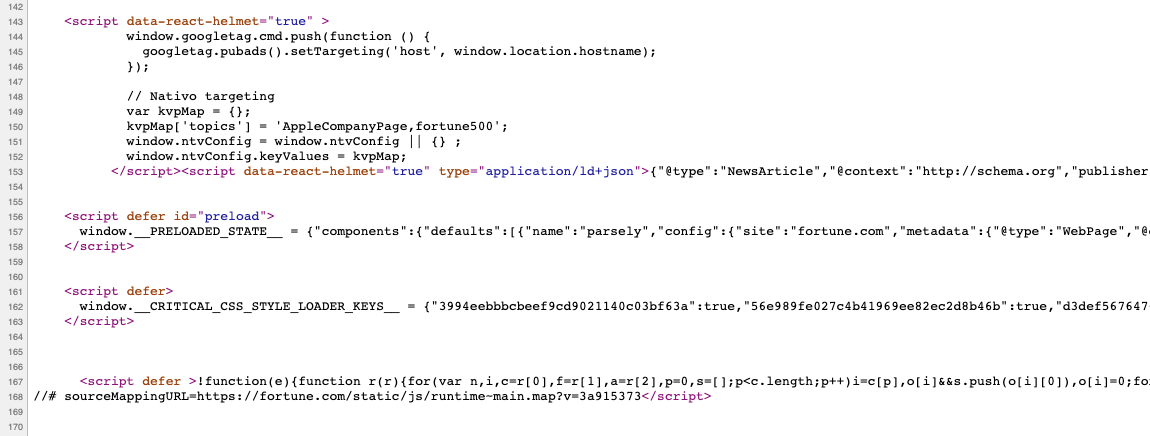

Therefore, we create our function to make our webpage request and then we extract our variable "__PRELOADED_STATE__". We can further narrow our response to the actual dictionary, **"company-information"**, that holds the data we seek. And finally, we convert that data to json format.

In [23]:
def soups(data):
    r = requests.get(data).text
    # select the the JSON from the html
    html = r[r.find('__PRELOADED_STATE__ = ') + len('__PRELOADED_STATE__ = '):]
    html = html[:html.find('};') + 1]
    
    # find company-information
    good_data = html[html.find('"company-information","config":') + len('"company-information","config":'):]
    good_data = good_data[:good_data.find('},') + 1]
    
    # convert to json
    j = json.loads(good_data)
    
    return j

In [28]:
# Call soup function and store output in a list
web = []

for url in urls:
    print(url)
    htmls = soups(url)
    print(htmls)
    web.append(htmls)
print(len(web))

https://fortune.com/company/zoom/fortune500/


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

**Example:** Second company in the list web page response.

In [ ]:
print(web[1])

### Scrape Data and Store in Dataframe

Next, we scrape the specific datsa we want from each dictionary in our list and put the data into a new dataframe. 

In [ ]:
m_df = pd.DataFrame()

In [ ]:
def get_data(name, col):

    lst = []
    val = ""
    for i in web: 
        for key, value in i.items():
            if key == name:
                val = value
            else:
                pass
        
        lst.append(val)
        
    m_df[col] = lst
    
    return m_df

In [ ]:
keys = ['ceo','website', 'ticker','marketValue']

cols = ['CEO', 'Website', 'Ticker','Market Cap']


for x,y in zip(keys, cols):
    m_df = get_data(x, y)
    #n_df = get_data(x, y)

In [ ]:
m_df.head()

And this makes up our second dataset.

# 4. Join and Sort

Now we can join our two datasets and sort the data so it shows the rankings from 1 to 1000. 

In [ ]:
# join
f1000_df = f500_df.join(m_df, how='left')

In [ ]:
print(f1000_df.shape)
f1000_df.head()

**Sort**

In [26]:
f1000_df = f1000_df.sort_values(by='rank', ignore_index=True)

NameError: name 'f1000_df' is not defined

In [25]:
f1000_df.head()

NameError: name 'f1000_df' is not defined

# Conclusion

Finally, we have our complete Fortune 500 dataset and we can create our csv file. 

In [ ]:
f1000_df.to_csv("Fortune_1000.csv", index=False)